<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

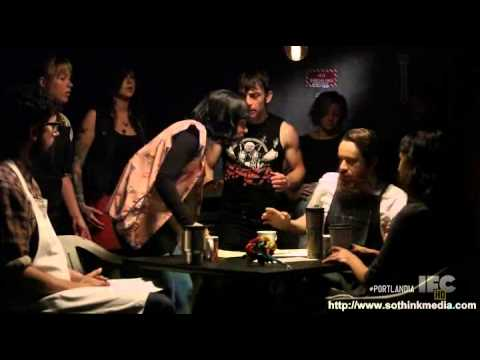

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/austie/PycharmProjects/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [4]:
# Start here

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [5]:
good_shops = shops[((shops['star_rating']==' 4.0 star rating ') | (shops['star_rating']==' 5.0 star rating '))]

In [6]:
bad_shops = shops[((shops['star_rating']!=' 4.0 star rating ') & (shops['star_rating']!=' 5.0 star rating '))]

In [7]:
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter

nlp = spacy.load("en_core_web_lg")

In [8]:
tokenizer = Tokenizer(nlp.vocab)

In [9]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [10]:
STOP_WORDS = nlp.Defaults.stop_words.union(['i', 'I', ' ', 'it', "it's", 'it.', 'the', 'this',])

In [11]:
tokens = []

for doc in tokenizer.pipe(good_shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False) & (token.text.lower() not in STOP_WORDS):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

good_shops['tokens'] = tokens

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [12]:
tokens = []

for doc in tokenizer.pipe(bad_shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False) & (token.text.lower() not in STOP_WORDS):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

bad_shops['tokens'] = tokens

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [13]:
wc_good = count(good_shops['tokens'])
wc_bad = count(bad_shops['tokens'])

In [14]:
wc_good.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
34,coffee,3383,6421,1.0,0.020857,0.020857,0.550977
115,place,2432,3389,2.0,0.011009,0.031866,0.396091
125,great,2174,2902,3.0,0.009427,0.041292,0.354072
270,good,1643,2180,4.0,0.007081,0.048374,0.267590
226,like,1486,2068,5.0,0.006717,0.055091,0.242020


In [15]:
wc_bad.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
33,coffee,827,1637,1.0,0.018732,0.018732,0.560298
127,place,597,875,2.0,0.010013,0.028745,0.404472
37,like,548,834,3.0,0.009543,0.038288,0.371274
15,good,441,599,4.0,0.006854,0.045142,0.298780
217,don't,340,430,5.0,0.004920,0.050063,0.230352


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [16]:
import squarify
import matplotlib.pyplot as plt

In [17]:
wc_top20good = wc_good[wc_good['rank'] <= 20]
wc_top20bad = wc_bad[wc_bad['rank'] <= 20]

In [18]:
wcdiff = wc_top20good.set_index('word').join(wc_top20bad.set_index('word'), on='word', how='inner', lsuffix='_good', rsuffix='_bad')
wcdiff['diff'] = abs(wcdiff['pct_total_good'] - wcdiff['pct_total_bad'])
wcdiff['diff'].sort_values(ascending=False)[:10]

word
great       0.005444
like        0.002826
coffee      0.002125
don't       0.001786
check-in    0.001096
place       0.000996
food        0.000994
1           0.000939
time        0.000788
pretty      0.000778
Name: diff, dtype: float64

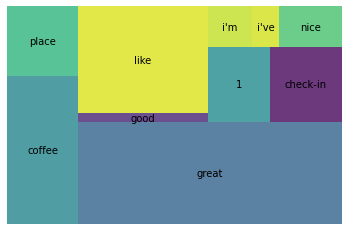

In [19]:
squarify.plot(sizes=wcdiff['diff'][:10], label=wcdiff.index[:10], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

